# POLI 175 - Lecture 09

## Classification II

## Classification

Loading packages:

In [1]:
## Loading the packages
using DataFrames
import CSV, Plots, GLM, StatsBase, Random
import LaTeXStrings, StatsPlots, Lowess, Gadfly, RegressionTables
import CovarianceMatrices, Econometrics, LinearAlgebra, MixedModelsExtras
import Missings, StatsAPI, FreqTables, EvalMetrics

## Running Example

### [Chile Survey](https://en.wikipedia.org/wiki/Chile)

In 1988, the [Chilean Dictator](https://en.wikipedia.org/wiki/Military_dictatorship_of_Chile) [Augusto Pinochet](https://en.wikipedia.org/wiki/Augusto_Pinochet) conducted a [referendum to whether he should step out](https://en.wikipedia.org/wiki/1988_Chilean_presidential_referendum).

The [FLACSO](https://en.wikipedia.org/wiki/Latin_American_Faculty_of_Social_Sciences) in Chile conducted a surver on 2700 respondents. We are going to build a model to predict their voting intentions.

| **Variable** | **Meaning** |
|:---:|---|
| region | A factor with levels:<br>- `C`, Central; <br>- `M`, Metropolitan Santiago area; <br>- `N`, North; <br>- `S`, South; <br>- `SA`, city of Santiago. |
| population | The population size of respondent's community. |
| sex | A factor with levels: <br>- `F`, female; <br>- `M`, male. |
| age | The respondent's age in years. |
| education | A factor with levels: <br>- `P`, Primary; <br>- `S`, Secondary; <br>- `PS`, Post-secondary. |
| income | The respondent's monthly income, in Pesos. |
| statusquo | A scale of support for the status-quo. |
| vote | A factor with levels: <br>- `A`, will abstain; <br>- `N`, will vote no (against Pinochet);<br>- `U`, is undecided; <br>- `Y`, will vote yes (for Pinochet). |

## Chile Survey

In [2]:
## Loading the data
chile = CSV.read(
    download("https://raw.githubusercontent.com/umbertomig/POLI175julia/main/data/chilesurvey.csv"), 
    DataFrame,
    missingstring = ["NA"]
); dropmissing!(chile)
chile.voteyes = ifelse.(chile.vote .== "Y", 1, 0)
first(chile, 3)

Row,region,population,sex,age,education,income,statusquo,vote,voteyes
,String3,Int64,String1,Int64,String3,Int64,Float64,String1,Int64
1,N,175000,M,65,P,35000,1.0082,Y,1
2,N,175000,M,29,PS,7500,-1.29617,N,0
3,N,175000,F,38,P,15000,1.23072,Y,1


## Logistic Regression

When running a regression for classification, accuracy is what matters: We don't care much about regression coefficients and explaining models to people.

In that sense, our ML tools do not need to give us the same results as a regression analysis software.

> All we need is a tool that runs the model, and spits out the predictions

This tool in Julia is the library [MLJ](https://alan-turing-institute.github.io/MLJ.jl/dev/)

How do we run a Logistic Regression in MLJ? Fortunately, MLJ has a very streamline process.

## Logistic Regression

### MLJ

MLJ comprises more the 180 ML models. It aggregates several packages in one.

It is a multiuse tool for ML, the same way 

[To install MLJ, check this source here](https://alan-turing-institute.github.io/MLJ.jl/dev/about_mlj/#Installation)

In [3]:
using Pkg
Pkg.add("MLJ")
Pkg.add("MLJLinearModels")
Pkg.add("MLJIteration")
Pkg.add("MLJBase")
Pkg.add("Optim")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


## Logistic Regression

### MLJ

Steps in MLJ:

1. Pre-process variables (before MLJ or using it, whatever more convenient)
1. Instantiate the model
1. Fit the model
1. Predict
1. Tuning and back again

And we will see variations of that. In the end of the course, you will have a work plan that contains all these steps in an automated order.

For now, let us run a Logistic Regression in MLJ.

## Logistic Regression in MLJ

**Step 00:** Load the packages.

In [4]:
# Loading the Logistic regression model
using MLJ, MLJIteration
import MLJLinearModels, MLJBase

## Logistic Regression in MLJ

**Step 01:** Pre-process the variables

We will use the `voteyes` as a target, and `age` and `income` as predictors.

In [5]:
# Chile dataset
first(chile, 2) |> pretty

┌─────────┬────────────┬─────────┬───────┬───────────┬────────┬────────────┬─────────┬─────────┐
│ region  │ population │ sex     │ age   │ education │ income │ statusquo  │ vote    │ voteyes │
│ String3 │ Int64      │ String1 │ Int64 │ String3   │ Int64  │ Float64    │ String1 │ Int64   │
│ Textual │ Count      │ Textual │ Count │ Textual   │ Count  │ Continuous │ Textual │ Count   │
├─────────┼────────────┼─────────┼───────┼───────────┼────────┼────────────┼─────────┼─────────┤
│ N       │ 175000     │ M       │ 65    │ P         │ 35000  │ 1.0082     │ Y       │ 1       │
│ N       │ 175000     │ M       │ 29    │ PS        │ 7500   │ -1.29617   │ N       │ 0       │
└─────────┴────────────┴─────────┴───────┴───────────┴────────┴────────────┴─────────┴─────────┘


In [6]:
# Pre-process
chile.income_log = log.(chile.income);
chile.pop_log = log.(chile.population);

In [7]:
# Creating the "data buckets" (y, X) and preprocessing accordingly
chileaux = coerce(
    chile[:,["voteyes", "income_log", "pop_log", "age"]], 
    :voteyes => Multiclass, 
    :income_log => Continuous,
    :pop_log => Continuous,
    :age=>Continuous)

y, X = unpack(chileaux, ==(:voteyes));

## Logistic Regression in MLJ

**Step 02:** Instantiate the model.

In [8]:
# Instantiate the logistic classifier:
logreg = MLJLinearModels.LogisticClassifier(lambda = 0, gamma = 0)

LogisticClassifier(
  lambda = 0, 
  gamma = 0, 
  penalty = :l2, 
  fit_intercept = true, 
  penalize_intercept = false, 
  scale_penalty_with_samples = true, 
  solver = nothing)

## Logistic Regression in MLJ

**Step 03:** Fit the model.

In [9]:
# Create my machine
machine1 = machine(logreg, X, y);
fit!(machine1);
params = fitted_params(machine1);

[ Info: Training machine(LogisticClassifier(lambda = 0, …), …).
┌ Info: Solver: MLJLinearModels.LBFGS{Optim.Options{Float64, Nothing}, NamedTuple{(), Tuple{}}}
│   optim_options: Optim.Options{Float64, Nothing}
└   lbfgs_options: NamedTuple{(), Tuple{}} NamedTuple()


In [10]:
# The parameters now
params

(classes = CategoricalArrays.CategoricalValue{Int64, UInt32}[0, 1],
 coefs = [:income_log => 0.15757057154922532, :pop_log => -0.24885378891520998, :age => 0.014932286550213935],
 intercept = 0.04018577576491836,)

## Logistic Regression in MLJ

**Step 04:** Predict

In [11]:
# Create my machine
ypred = predict(machine1, X)
println(ypred[1])
println(y[1])

UnivariateFinite{Multiclass{2}}(0=>0.585, 1=>0.415)
1


## Logistic Regression in MLJ

**Step 04:** Predict

In [12]:
# Create my machine
ypred_mode = predict_mode(machine1, X);
ypred_mode[1]

CategoricalArrays.CategoricalValue{Int64, UInt32} 0

## Logistic Regression in MLJ

**Step 05:** Evaluate and tuning (many [measures](https://juliaai.github.io/StatisticalMeasures.jl/dev/auto_generated_list_of_measures/#aliases))

In [13]:
FreqTables.freqtable(y, ypred_mode)

2×2 Named Matrix{Int64}
Dim1 ╲ Dim2 │    0     1
────────────┼───────────
0           │ 1548    47
1           │  786    50

In [14]:
confusion_matrix(ypred_mode, y) 

          ┌─────────────┐
          │Ground Truth │
┌─────────┼──────┬──────┤
│Predicted│  0   │  1   │
├─────────┼──────┼──────┤
│    0    │ 1548 │ 786  │
├─────────┼──────┼──────┤
│    1    │  47  │  50  │
└─────────┴──────┴──────┘


## Logistic Regression in MLJ

**Step 05:** Evaluate and tuning

In [15]:
accuracy(y, ypred_mode)

0.6573426573426573

In [16]:
recall(y, ypred_mode)

┌ Warning: Levels not explicitly ordered. Using the order CategoricalArrays.CategoricalValue{Int64, UInt32}[0, 1]. The "positive" level is 1. 
└ @ StatisticalMeasures.ConfusionMatrices ~/.julia/packages/StatisticalMeasures/Wnt7C/src/confusion_matrices.jl:333


0.5154639175257731

In [17]:
ppv(y, ypred_mode) # Precision

┌ Warning: Levels not explicitly ordered. Using the order CategoricalArrays.CategoricalValue{Int64, UInt32}[0, 1]. The "positive" level is 1. 
└ @ StatisticalMeasures.ConfusionMatrices ~/.julia/packages/StatisticalMeasures/Wnt7C/src/confusion_matrices.jl:333


0.05980861244019142

## Logistic Regression in MLJ

**Step 05:** Evaluate and tuning

In [18]:
MLJ.f1score(y, ypred_mode)

┌ Warning: Levels not explicitly ordered. Using the order CategoricalArrays.CategoricalValue{Int64, UInt32}[0, 1]. The "positive" level is 1. 
└ @ StatisticalMeasures.ConfusionMatrices ~/.julia/packages/StatisticalMeasures/Wnt7C/src/confusion_matrices.jl:333


0.10718113612004287

In [19]:
MLJ.macro_f1score(y, ypred_mode)

0.44758395060010797

In [20]:
MLJ.micro_f1score(y, ypred_mode)

0.6573426573426573

## Logistic Regression in MLJ

**Step 05:** Evaluate and tuning

In [21]:
ypred_prob = pdf.(ypred, 1);

┌ Warning: Skipped marker arg none.
└ @ Plots ~/.julia/packages/Plots/sxUvK/src/args.jl:1149
┌ Warning: Skipped marker arg none.
└ @ Plots ~/.julia/packages/Plots/sxUvK/src/args.jl:1149


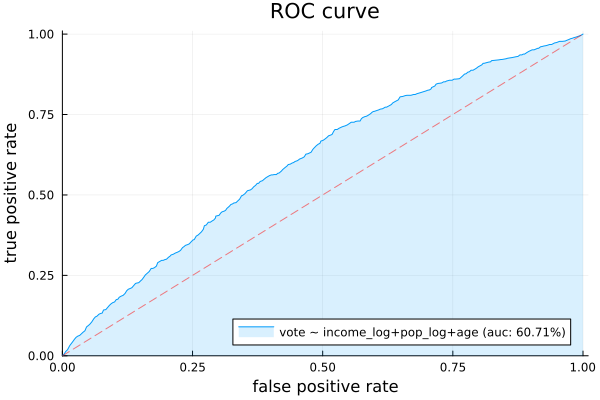

In [22]:
EvalMetrics.rocplot(chile.voteyes, 
    ypred_prob, 
    label = "vote ~ income_log+pop_log+age", 
    diagonal = true)

## Logistic Regression

Now, let us specify the model for `voteyes` using a mix of categorical and continuous variables: 

**Step 01:** Pre-process the variables

In [23]:
# Chile dataset
first(chile, 2)

Row,region,population,sex,age,education,income,statusquo,vote,voteyes,income_log,pop_log
,String3,Int64,String1,Int64,String3,Int64,Float64,String1,Int64,Float64,Float64
1,N,175000,M,65,P,35000,1.0082,Y,1,10.4631,12.0725
2,N,175000,M,29,PS,7500,-1.29617,N,0,8.92266,12.0725


In [24]:
# Adapted from @xiaodaigh: https://github.com/xiaodaigh/DataConvenience.jl
function onehot!(df::AbstractDataFrame, 
        col, cate = sort(unique(df[!, col])); 
        outnames = Symbol.(col, :_, cate))
    transform!(df, @. col => ByRow(isequal(cate)) .=> outnames)
end

onehot!(chile, :region);
onehot!(chile, :education);
onehot!(chile, :sex);

In [25]:
# Chile dataset
first(chile, 2)

Row,region,population,sex,age,education,income,statusquo,vote,voteyes,income_log,pop_log,region_C,region_M,region_N,region_S,region_SA,education_P,education_PS,education_S,sex_F,sex_M
,String3,Int64,String1,Int64,String3,Int64,Float64,String1,Int64,Float64,Float64,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool,Bool
1,N,175000,M,65,P,35000,1.0082,Y,1,10.4631,12.0725,false,false,true,false,false,true,false,false,false,true
2,N,175000,M,29,PS,7500,-1.29617,N,0,8.92266,12.0725,false,false,true,false,false,false,true,false,false,true


## Logistic Regression

**Step 01:** Pre-process the variables

In [26]:
# Pre-process
features = ["voteyes", "income_log", "pop_log", "age",
    "region_M", "region_N", "region_S", "region_SA", # Dropping region_C
    "education_PS", "education_S",                   # Dropping education_P
    "sex_M"]                                         # Dropping sex_P
y, X = unpack(
    chile[:,features],
    ==(:voteyes),
    c -> true;
    :voteyes      => Multiclass,
    :income_log   => Continuous,
    :pop_log      => Continuous,
    :age          => Continuous,
    :region_M     => Multiclass,
    :region_N     => Multiclass,
    :region_S     => Multiclass,
    :region_SA    => Multiclass,
    :sex_M        => Multiclass,
    :education_S  => Multiclass,
    :education_PS => Multiclass,
);

In [27]:
# Checking it
schema(X)

┌──────────────┬───────────────┬────────────────────────────────┐
│ names        │ scitypes      │ types                          │
├──────────────┼───────────────┼────────────────────────────────┤
│ income_log   │ Continuous    │ Float64                        │
│ pop_log      │ Continuous    │ Float64                        │
│ age          │ Continuous    │ Float64                        │
│ region_M     │ Multiclass{2} │ CategoricalValue{Bool, UInt32} │
│ region_N     │ Multiclass{2} │ CategoricalValue{Bool, UInt32} │
│ region_S     │ Multiclass{2} │ CategoricalValue{Bool, UInt32} │
│ region_SA    │ Multiclass{2} │ CategoricalValue{Bool, UInt32} │
│ education_PS │ Multiclass{2} │ CategoricalValue{Bool, UInt32} │
│ education_S  │ Multiclass{2} │ CategoricalValue{Bool, UInt32} │
│ sex_M        │ Multiclass{2} │ CategoricalValue{Bool, UInt32} │
└──────────────┴───────────────┴────────────────────────────────┘


## Logistic Regression in MLJ

**Step 02:** Instantiate the model.

In [28]:
# Instantiate the logistic classifier
logreg2 = MLJLinearModels.LogisticClassifier(lambda = 0, gamma = 0)

LogisticClassifier(
  lambda = 0, 
  gamma = 0, 
  penalty = :l2, 
  fit_intercept = true, 
  penalize_intercept = false, 
  scale_penalty_with_samples = true, 
  solver = nothing)

## Logistic Regression in MLJ

**Step 03:** Fit the model.

In [29]:
# Create my machine
machine2 = machine(logreg2, X, y, scitype_check_level = 0);
MLJ.fit!(machine2);
params = fitted_params(machine2);

[ Info: Training machine(LogisticClassifier(lambda = 0, …), …).
┌ Info: Solver: MLJLinearModels.LBFGS{Optim.Options{Float64, Nothing}, NamedTuple{(), Tuple{}}}
│   optim_options: Optim.Options{Float64, Nothing}
└   lbfgs_options: NamedTuple{(), Tuple{}} NamedTuple()


In [30]:
# The parameters now
MLJ.print(params)

(classes = CategoricalArrays.CategoricalValue{Int64, UInt32}[0, 1], coefs = [:income_log => 0.22329465039579693, :pop_log => -0.26176098215386195, :age => 0.009140252241288192, :region_M => 0.3828994628090048, :region_N => 0.5535687322812493, :region_S => 0.41952912935927783, :region_SA => 0.17696020797798076, :education_PS => -0.591400470355785, :education_S => -0.4256820698674749, :sex_M => -0.2580614090229084], intercept = -0.0912551500981765)

## Logistic Regression in MLJ

**Step 04:** Predict

In [31]:
# Create my machine
ypred2 = MLJ.predict(machine2, X)
println(ypred2[1])
println(y[1])

UnivariateFinite{Multiclass{2}}(0=>0.506, 1=>0.494)
1


## Logistic Regression in MLJ

**Step 04:** Predict

In [32]:
# Create my machine
ypred_mode2 = MLJ.predict_mode(machine2, X);
ypred_mode2[1]

CategoricalArrays.CategoricalValue{Int64, UInt32} 0

## Logistic Regression in MLJ

**Step 05:** Evaluate and tuning (many [measures](https://juliaai.github.io/StatisticalMeasures.jl/dev/auto_generated_list_of_measures/#aliases))

In [33]:
FreqTables.freqtable(y, ypred_mode2)

2×2 Named Matrix{Int64}
Dim1 ╲ Dim2 │    0     1
────────────┼───────────
0           │ 1480   115
1           │  700   136

In [34]:
MLJ.confusion_matrix(ypred_mode2, y) 

          ┌─────────────┐
          │Ground Truth │
┌─────────┼──────┬──────┤
│Predicted│  0   │  1   │
├─────────┼──────┼──────┤
│    0    │ 1480 │ 700  │
├─────────┼──────┼──────┤
│    1    │ 115  │ 136  │
└─────────┴──────┴──────┘


## Logistic Regression in MLJ

**Step 05:** Evaluate and tuning

In [35]:
MLJ.accuracy(y, ypred_mode2)

0.6647470176881941

In [36]:
MLJ.recall(y, ypred_mode2)

┌ Warning: Levels not explicitly ordered. Using the order CategoricalArrays.CategoricalValue{Int64, UInt32}[0, 1]. The "positive" level is 1. 
└ @ StatisticalMeasures.ConfusionMatrices ~/.julia/packages/StatisticalMeasures/Wnt7C/src/confusion_matrices.jl:333


0.5418326693227091

In [37]:
MLJ.ppv(y, ypred_mode2)

┌ Warning: Levels not explicitly ordered. Using the order CategoricalArrays.CategoricalValue{Int64, UInt32}[0, 1]. The "positive" level is 1. 
└ @ StatisticalMeasures.ConfusionMatrices ~/.julia/packages/StatisticalMeasures/Wnt7C/src/confusion_matrices.jl:333


0.16267942583732053

## Logistic Regression in MLJ

**Step 05:** Evaluate and tuning

In [38]:
MLJ.f1score(y, ypred_mode2)

┌ Warning: Levels not explicitly ordered. Using the order CategoricalArrays.CategoricalValue{Int64, UInt32}[0, 1]. The "positive" level is 1. 
└ @ StatisticalMeasures.ConfusionMatrices ~/.julia/packages/StatisticalMeasures/Wnt7C/src/confusion_matrices.jl:333


0.250229990800368

In [39]:
MLJ.macro_f1score(y, ypred_mode2)

0.5171679755326344

In [40]:
MLJ.micro_f1score(y, ypred_mode2)

0.6647470176881941

## Logistic Regression in MLJ

**Step 05:** Evaluate and tuning

In [41]:
ypred_prob2 = MLJ.pdf.(ypred2, 1);

┌ Warning: Skipped marker arg none.
└ @ Plots ~/.julia/packages/Plots/sxUvK/src/args.jl:1149
┌ Warning: Skipped marker arg none.
└ @ Plots ~/.julia/packages/Plots/sxUvK/src/args.jl:1149
┌ Warning: Skipped marker arg none.
└ @ Plots ~/.julia/packages/Plots/sxUvK/src/args.jl:1149
┌ Warning: Skipped marker arg none.
└ @ Plots ~/.julia/packages/Plots/sxUvK/src/args.jl:1149


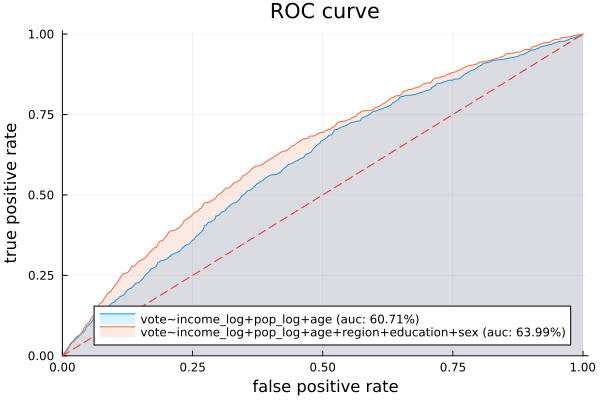

In [42]:
EvalMetrics.rocplot([chile.voteyes, chile.voteyes], 
    [ypred_prob, ypred_prob2],
    label = ["vote~income_log+pop_log+age" "vote~income_log+pop_log+age+region+education+sex";])

# Generative Models of Classification

## Generative Models of Classification

Logistic regression involves modeling the probability of a response given a set of parameters. It uses the logistic link for the *conditional distribution*
    
$$ \mathbb{E}(Y = 1 | X = x) \ = \ \mathbb{P}(Y = 1 | X = x) \ = \ \text{Logit}(\beta_0 + \cdots + \beta_pX_p) $$

Another approach is to model the distribution for each values of $Y$. And then, use the Bayes Theorem to get the conditional distributions.

[These are called *generative models for statistical classification*. It models the joint distribution, instead of the conditional probability (like in *discriminative models*)](https://en.wikipedia.org/wiki/Generative_model)

But why?

1. Separation
1. Small sample size

## Generative Models of Classification

Let $\pi_k$ the prior probability of $Y = k$.

And let $f_k(x) = \mathbb{P}(X = x | Y = k)$ the density function for an observation that comes from the $k$-th class.

According to the Bayes theorem:

$$ \mathbb{P}(Y = k | X = x) \ = \ \dfrac{\pi_kf_k(x)}{\sum_l \pi_l f_l(x)} $$

Now, estimating $\pi_k$ is easy: we compute the fraction that belongs to the $k$-th class. How about $f$?

Different estimators are going to give us different classifiers.

## Generative Models of Classification

### [Linear Discriminant Analysis](https://en.wikipedia.org/wiki/Linear_discriminant_analysis)

Suppose we have only one variable $x$ and $f_k$ is Gaussian:

$$ x \sim N(\mu_k, \sigma_k^2) $$

And assuming further that the draws have the same variance: $\sigma^2 = \sigma_k^2 \forall k$

Computing the log of the posterior gives us:

$$ \delta_k(x) \ = \ x \dfrac{\mu_k}{\sigma^2} - \dfrac{\mu_k^2}{2\sigma^2} + \log(\pi_k) $$

## Generative Models of Classification

### [Linear Discriminant Analysis](https://en.wikipedia.org/wiki/Linear_discriminant_analysis)

And the decision for which class the $x$ belongs is simple: **Whichever has the highest probability is the "winner"**.

1. Let $x$

2. Compute $\delta_0(x)$

3. Compute $\delta_1(x)$

4. The highest is the winner :-)

## Generative Models of Classification

### [Linear Discriminant Analysis](https://en.wikipedia.org/wiki/Linear_discriminant_analysis)

But how the decision boundary looks like? We need to find the *indifference point*:

$$ \delta_1(x) = \delta_0(x) $$

Do the algebra, and you are going to find:

$$ x \ = \ \dfrac{\mu_0 + \mu_1}{2} $$



## Generative Models of Classification

### [Linear Discriminant Analysis](https://en.wikipedia.org/wiki/Linear_discriminant_analysis)

![img lda](https://github.com/umbertomig/POLI175julia/blob/c9b0555e3e97778495bee72746aee43ddf3226d7/img/ldabounds.png?raw=true)

## Generative Models of Classification

### [Linear Discriminant Analysis](https://en.wikipedia.org/wiki/Linear_discriminant_analysis)

And the LDA approximate the quantities of interest by doing the following:

1. $$ \widehat{\mu}_k  \ = \ \dfrac{1}{n_k} \sum_{i:y_i = k}x_i $$


2. $$ \widehat{\sigma}^2 \ = \ \dfrac{1}{n - K} \sum_{k=1}^K\sum_{i:y_i = k}(x_i - \widehat{\mu}_k)^2 $$


3. $$ \widehat{\pi}_k \ = \ \dfrac{n_k}{n} $$

Note that you can classify more than two categories.

## Generative Models of Classification

### [Linear Discriminant Analysis](https://en.wikipedia.org/wiki/Linear_discriminant_analysis)

The chance that $x$ belongs to $y=k$ is going to be:

$$ \widehat{\delta}_k(x) \ = \ x \dfrac{\widehat{\mu}_k}{\widehat{\sigma}^2} - \dfrac{\widehat{\mu}_k^2}{2\widehat{\sigma}^2} + \log(\widehat{\pi}_k) $$

Note that this is a linear function, so the name `Linear Discriminant Analysis`.

Now let's fit it using `MLJ`. First, adding the package.

## Generative Models of Classification

### MLJ detour

How to find **MLJ** models? Check the command `models()`.

In [43]:
MLJ.models()

230-element Vector{NamedTuple{(:name, :package_name, :is_supervised, :abstract_type, :deep_properties, :docstring, :fit_data_scitype, :human_name, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :inverse_transform_scitype, :is_pure_julia, :is_wrapper, :iteration_parameter, :load_path, :package_license, :package_url, :package_uuid, :predict_scitype, :prediction_type, :reporting_operations, :reports_feature_importances, :supports_class_weights, :supports_online, :supports_training_losses, :supports_weights, :transform_scitype, :input_scitype, :target_scitype, :output_scitype)}}:
 (name = ABODDetector, package_name = OutlierDetectionNeighbors, ... )
 (name = ABODDetector, package_name = OutlierDetectionPython, ... )
 (name = ARDRegressor, package_name = MLJScikitLearnInterface, ... )
 (name = AdaBoostClassifier, package_name = MLJScikitLearnInterface, ... )
 (name = AdaBoostRegressor, package_name = MLJScikitLearnInterface, ... )
 (name = AdaBoostStu

## Generative Models of Classification

### MLJ detour

And to check a particular model (in this case, the LDA, we do) `models()[position_model]`.

In [44]:
# LDA is 105!
MLJ.models()[105]

(name = "LDA",
 package_name = "MultivariateStats",
 is_supervised = true,
 abstract_type = Probabilistic,
 deep_properties = (),
 docstring = "```\nLDA\n```\n\nA model type for constructing a linea...",
 fit_data_scitype =
     Tuple{Table{<:AbstractVector{<:Continuous}}, AbstractVector{<:Finite}},
 human_name = "linear discriminant analysis model",
 hyperparameter_ranges =
     (nothing, nothing, nothing, nothing, nothing, nothing),
 hyperparameter_types = ("Symbol",
                         "StatsBase.CovarianceEstimator",
                         "StatsBase.CovarianceEstimator",
                         "Int64",
                         "Float64",
                         "Distances.SemiMetric"),
 hyperparameters = (:method, :cov_w, :cov_b, :outdim, :regcoef, :dist),
 implemented_methods = [:clean!, :fit, :fitted_params, :predict, :transform],
 inverse_transform_scitype = Unknown,
 is_pure_julia = true,
 is_wrapper = false,
 iteration_parameter = nothing,
 load_path = "MLJMultivari

## Generative Models of Classification

### MLJ detour

After finding it, we need to install the model. To that, run:

```julia
Pkg.add("package_name")
Pkg.add("load_path_without_the_period")
```

In [45]:
# Adding LDA (+other MV stats) method
Pkg.add("MultivariateStats")
Pkg.add("MLJMultivariateStatsInterface")
import MultivariateStats, MLJMultivariateStatsInterface

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


## Generative Models of Classification

### MLJ detour

But these models are the ones that you could install. Not necessarily in your computer. 

To check the stuff you already installed, check the command `localmodels()`.

In [46]:
MLJ.localmodels()

38-element Vector{NamedTuple{(:name, :package_name, :is_supervised, :abstract_type, :deep_properties, :docstring, :fit_data_scitype, :human_name, :hyperparameter_ranges, :hyperparameter_types, :hyperparameters, :implemented_methods, :inverse_transform_scitype, :is_pure_julia, :is_wrapper, :iteration_parameter, :load_path, :package_license, :package_url, :package_uuid, :predict_scitype, :prediction_type, :reporting_operations, :reports_feature_importances, :supports_class_weights, :supports_online, :supports_training_losses, :supports_weights, :transform_scitype, :input_scitype, :target_scitype, :output_scitype)}}:
 (name = BayesianLDA, package_name = MultivariateStats, ... )
 (name = BayesianSubspaceLDA, package_name = MultivariateStats, ... )
 (name = ConstantClassifier, package_name = MLJModels, ... )
 (name = ConstantRegressor, package_name = MLJModels, ... )
 (name = ContinuousEncoder, package_name = MLJModels, ... )
 (name = DeterministicConstantClassifier, package_name = MLJModel

## Generative Models of Classification

### MLJ detour

In `localmodels()`, the LDA is in position 17.

In [47]:
MLJ.localmodels()[17]

(name = "LDA",
 package_name = "MultivariateStats",
 is_supervised = true,
 abstract_type = Probabilistic,
 deep_properties = (),
 docstring = "```\nLDA\n```\n\nA model type for constructing a linea...",
 fit_data_scitype =
     Tuple{Table{<:AbstractVector{<:Continuous}}, AbstractVector{<:Finite}},
 human_name = "linear discriminant analysis model",
 hyperparameter_ranges =
     (nothing, nothing, nothing, nothing, nothing, nothing),
 hyperparameter_types = ("Symbol",
                         "StatsBase.CovarianceEstimator",
                         "StatsBase.CovarianceEstimator",
                         "Int64",
                         "Float64",
                         "Distances.SemiMetric"),
 hyperparameters = (:method, :cov_w, :cov_b, :outdim, :regcoef, :dist),
 implemented_methods = [:clean!, :fit, :fitted_params, :predict, :transform],
 inverse_transform_scitype = Unknown,
 is_pure_julia = true,
 is_wrapper = false,
 iteration_parameter = nothing,
 load_path = "MLJMultivari

## Generative Models of Classification

### [Linear Discriminant Analysis](https://en.wikipedia.org/wiki/Linear_discriminant_analysis)

**Step 01 (pre-process):** Already done.

**Step 02 (instantiate model):** Needs to be done

.
.
.

**Step 05 (evaluate model):** Needs to be done

This to say: Once the data is in shape, you only need to rerun steps 02 to 05.

In [48]:
# Instantiate the linear discriminant classifier
ldan = MLJMultivariateStatsInterface.LDA()

LDA(
  method = :gevd, 
  cov_w = StatsBase.SimpleCovariance(false), 
  cov_b = StatsBase.SimpleCovariance(false), 
  outdim = 0, 
  regcoef = 1.0e-6, 
  dist = Distances.SqEuclidean(0.0))

## Generative Models of Classification

### [Linear Discriminant Analysis](https://en.wikipedia.org/wiki/Linear_discriminant_analysis)

**Step 03:** Fit the model.

In [49]:
# Create my machine
machine3 = machine(ldan, X, y, scitype_check_level = 0);
MLJ.fit!(machine3);
params = fitted_params(machine3);

[ Info: Training machine(LDA(method = gevd, …), …).


In [50]:
# The parameters now
MLJ.print(params)

(classes = [1, 0], projection_matrix = [-0.010562517133240284; 0.00875349367656888; -0.00043154517263252923; -0.028966960775684295; -0.02643554226038635; -0.0196859437661005; -0.005967495775082974; 0.023871212381202316; 0.017088068060889715; 0.010611978648207841;;])

## Generative Models of Classification

### [Linear Discriminant Analysis](https://en.wikipedia.org/wiki/Linear_discriminant_analysis)

**Step 04:** Predict

In [51]:
# Create my machine
ypred3 = MLJ.predict(machine3, X)
println(ypred3[1])
println(y[1])

UnivariateFinite{Multiclass{2}}(0=>0.5, 1=>0.5)
1


## Generative Models of Classification

### [Linear Discriminant Analysis](https://en.wikipedia.org/wiki/Linear_discriminant_analysis)

**Step 04:** Predict

In [52]:
# Create my machine
ypred_mode3 = MLJ.predict_mode(machine3, X);
ypred_mode3[1]

CategoricalArrays.CategoricalValue{Int64, UInt32} 1

## Generative Models of Classification

### [Linear Discriminant Analysis](https://en.wikipedia.org/wiki/Linear_discriminant_analysis)

**Step 05:** Evaluate and tuning (many [measures](https://juliaai.github.io/StatisticalMeasures.jl/dev/auto_generated_list_of_measures/#aliases))

In [53]:
MLJ.confusion_matrix(ypred_mode3, y) 

          ┌─────────────┐
          │Ground Truth │
┌─────────┼──────┬──────┤
│Predicted│  0   │  1   │
├─────────┼──────┼──────┤
│    0    │ 1015 │ 338  │
├─────────┼──────┼──────┤
│    1    │ 580  │ 498  │
└─────────┴──────┴──────┘


## Generative Models of Classification

### [Linear Discriminant Analysis](https://en.wikipedia.org/wiki/Linear_discriminant_analysis)

**Step 05:** Evaluate and tuning

┌ Warning: Skipped marker arg none.
└ @ Plots ~/.julia/packages/Plots/sxUvK/src/args.jl:1149
┌ Warning: Skipped marker arg none.
└ @ Plots ~/.julia/packages/Plots/sxUvK/src/args.jl:1149
┌ Warning: Skipped marker arg none.
└ @ Plots ~/.julia/packages/Plots/sxUvK/src/args.jl:1149
┌ Warning: Skipped marker arg none.
└ @ Plots ~/.julia/packages/Plots/sxUvK/src/args.jl:1149
┌ Warning: Skipped marker arg none.
└ @ Plots ~/.julia/packages/Plots/sxUvK/src/args.jl:1149
┌ Warning: Skipped marker arg none.
└ @ Plots ~/.julia/packages/Plots/sxUvK/src/args.jl:1149


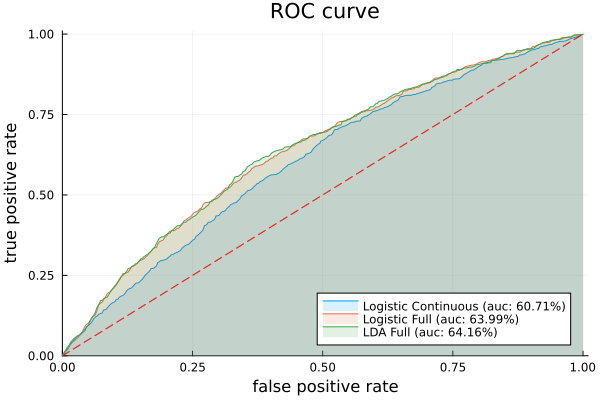

In [54]:
ypred_prob3 = MLJ.pdf.(ypred3, 1);
EvalMetrics.rocplot([chile.voteyes, chile.voteyes, chile.voteyes], 
    [ypred_prob, ypred_prob2, ypred_prob3],
    label = ["Logistic Continuous" "Logistic Full" "LDA Full";])

## Generative Models of Classification

### Quadratic Discriminant Analysis

The main difference is that it assumes that every observation has its own covariance matrix. It drops the `same-sigma` assumption.

### Naïve Bayes

Instead of assuming that $f$ belongs to a class of distributions (e.g., Normal), it assumes that the $f$s are independent. This dropx the `Multivariate-Normal` assumption.

For $p$ predictors, you make only assumptions about each $x_{ik}$:

$$ f_k(x) \ = \ f_{k1}(x_1)\times \cdots \times f_{kp}(x_p) $$

And you assume a normal distribution (Gaussian shape) for each variable...

## Generative Models of Classification

**Decision Boundaries for these three Generative Models**

![img](https://github.com/umbertomig/POLI175julia/blob/c9b0555e3e97778495bee72746aee43ddf3226d7/img/ldaxqdaxnb.png?raw=true)

<font color='purple'>Purple</font>: Naïve Bayes; <font color='black'>Black</font>: LDA; <font color='green'>Green</font>: QDA.

In PS3 you will run all these models and analyze them.

## Classification

### [K-Nearest Neighbors Classifier](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm)

Given an integer $K$, and a test observation, it says that:

$$ \mathbb{P}(Y = j| X = x_0) \ = \ \dfrac{1}{K}\sum_{i \in N_0} I(y_i = j) $$

**Meaning**: classify the observation based on the class of the closest $K$ obs: The one more frequent is the winner.
    
**Closest**: Imply an idea of a *metric*.

## Classification

### K-Nearest Neighbors Classifier

![img](https://github.com/umbertomig/POLI175julia/blob/c9b0555e3e97778495bee72746aee43ddf3226d7/img/knn1.png?raw=true)

## Classification

### K-Nearest Neighbors Classifier

![img](https://github.com/umbertomig/POLI175julia/blob/c9b0555e3e97778495bee72746aee43ddf3226d7/img/knn2.png?raw=true)

## Classification

### K-Nearest Neighbors Classifier in MLJ

In [55]:
models()[95]

(name = "KNNClassifier",
 package_name = "NearestNeighborModels",
 is_supervised = true,
 abstract_type = Probabilistic,
 deep_properties = (),
 docstring = "```\nKNNClassifier\n```\n\nA model type for constructi...",
 fit_data_scitype =
     Union{Tuple{Table{<:AbstractVector{<:Continuous}}, AbstractVector{<:Finite}}, Tuple{Table{<:AbstractVector{<:Continuous}}, AbstractVector{<:Finite}, AbstractVector{<:Union{Continuous, Count}}}},
 human_name = "K-nearest neighbor classifier",
 hyperparameter_ranges =
     (nothing, nothing, nothing, nothing, nothing, nothing),
 hyperparameter_types = ("Int64",
                         "Symbol",
                         "Distances.Metric",
                         "Int64",
                         "Bool",
                         "NearestNeighborModels.KNNKernel"),
 hyperparameters = (:K, :algorithm, :metric, :leafsize, :reorder, :weights),
 implemented_methods = [:clean!, :fit, :fitted_params, :predict],
 inverse_transform_scitype = Unknown,
 is_pu

## Classification

### K-Nearest Neighbors Classifier in MLJ

In [56]:
Pkg.add("NearestNeighborModels")
import NearestNeighborModels

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


## Generative Models of Classification

### K-Nearest Neighbors Classifier in MLJ

In [57]:
knnclass = NearestNeighborModels.KNNClassifier(K = 10)
machine4 = machine(knnclass, X, y, scitype_check_level = 0);
MLJ.fit!(machine4);
ypred4 = MLJ.predict(machine4, X);
ypred_mode4 = MLJ.predict_mode(machine4, X);
ypred_prob4 = MLJ.pdf.(ypred4, 1);

[ Info: Training machine(KNNClassifier(K = 10, …), …).


## Generative Models of Classification

### K-Nearest Neighbors Classifier in MLJ

In [58]:
MLJ.confusion_matrix(ypred_mode4, y)

          ┌─────────────┐
          │Ground Truth │
┌─────────┼──────┬──────┤
│Predicted│  0   │  1   │
├─────────┼──────┼──────┤
│    0    │ 1517 │ 663  │
├─────────┼──────┼──────┤
│    1    │  78  │ 173  │
└─────────┴──────┴──────┘


## Generative Models of Classification

### K-Nearest Neighbors Classifier in MLJ

┌ Warning: Skipped marker arg none.
└ @ Plots ~/.julia/packages/Plots/sxUvK/src/args.jl:1149
┌ Warning: Skipped marker arg none.
└ @ Plots ~/.julia/packages/Plots/sxUvK/src/args.jl:1149
┌ Warning: Skipped marker arg none.
└ @ Plots ~/.julia/packages/Plots/sxUvK/src/args.jl:1149
┌ Warning: Skipped marker arg none.
└ @ Plots ~/.julia/packages/Plots/sxUvK/src/args.jl:1149
┌ Warning: Skipped marker arg none.
└ @ Plots ~/.julia/packages/Plots/sxUvK/src/args.jl:1149
┌ Warning: Skipped marker arg none.
└ @ Plots ~/.julia/packages/Plots/sxUvK/src/args.jl:1149
┌ Warning: Skipped marker arg none.
└ @ Plots ~/.julia/packages/Plots/sxUvK/src/args.jl:1149
┌ Warning: Skipped marker arg none.
└ @ Plots ~/.julia/packages/Plots/sxUvK/src/args.jl:1149


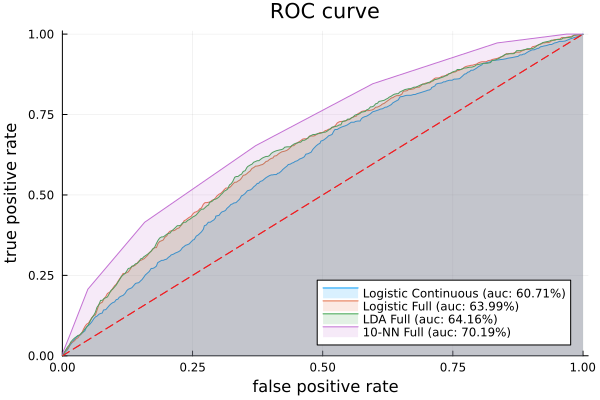

In [60]:
EvalMetrics.rocplot([chile.voteyes, chile.voteyes, chile.voteyes, chile.voteyes], 
    [ypred_prob, ypred_prob2, ypred_prob3, ypred_prob4],
    label = ["Logistic Continuous" "Logistic Full" "LDA Full" "10-NN Full";],
)

# Questions?

# See you next class
